In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("whitegrid")
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Load and Prepare Data Set<a id="1-2"></a>

In [2]:
# load data set
data = pd.read_csv('crypto-markets.csv', parse_dates=['Date'],index_col='Date')

In [3]:
# display appointment data set
data.head()

,Open,High,Low,Close,Adj Close,Volume,oc_diff,symbol,Name
Date,,,,,,,,,
2017-12-31,12897.700195,14377.400391,12755.599609,14156.400391,14156.400391,12136299520,1258.700195,BTC,Bitcoin
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,-455.000000,BTC,Bitcoin
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,1357.099609,BTC,Bitcoin
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,222.799805,BTC,Bitcoin
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,328.500000,BTC,Bitcoin


According to Business Insider, the top cryptocurrencies to invest in are:
1. Bitcoin (BTC)
2. Ethereum (ETH)
3. Litecoin (LTC)
4. Bitcoin Cash (BCH)
5. Ripple (XRP)
6. Monero (XMR)
7. Zcash (ZEC)

So we will do some analysis and prediction for these 7 cryptocurrencies. 

In [4]:
# select Bitcoin (BTC), Litecoin (LTC), Ethereum (ETH), Zcash (ZEC), Ripple (XRP), Monero (XMR) and Bitcoin Cash (BCH)
data = data[data.symbol.isin(['BTC', 'LTC', 'ETH', 'ZEC', 'XRP', 'XMR', 'BCH'])]

In [5]:
# display total number of records for the 7 cryptocurrencies
data.Name.value_counts()

Bitcoin         1824
Etherium        1824
Litecoin        1824
Bitcoin Cash    1824
Ripple          1824
Monero          1824
Zcash           1824
Name: Name, dtype: int64

In [6]:
# display data volumn and types 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12768 entries, 2017-12-31 to 2022-12-28
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       12768 non-null  float64
 1   High       12768 non-null  float64
 2   Low        12768 non-null  float64
 3   Close      12768 non-null  float64
 4   Adj Close  12768 non-null  float64
 5   Volume     12768 non-null  int64  
 6   oc_diff    12768 non-null  float64
 7   symbol     12768 non-null  object 
 8   Name       12768 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 997.5+ KB


## 2. Data Quality Assessment<a id="2"></a>

### Check Missing Values<a id="2-1"></a>

In [7]:
# check if data set contains missing values
print(data.isnull().sum())

# assert that there are no missing values
assert data.notnull().all().all()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
oc_diff      0
symbol       0
Name         0
dtype: int64


No missing value exist in this data set.

### Check Duplicated Values<a id="2-2"></a>

In [8]:
# check if data set contains duplicated records
print(data.duplicated().sum())

0


There is no duplicated appointments record in this data set. The data is clean.

## 3. Exploratory Data Analysis and Feature Engineering<a id="3"></a>

### Market Capitalization and Transaction Volume<a id="3-1"></a>

Check market capitalization and transaction volume for each cryptocurrency we choose.

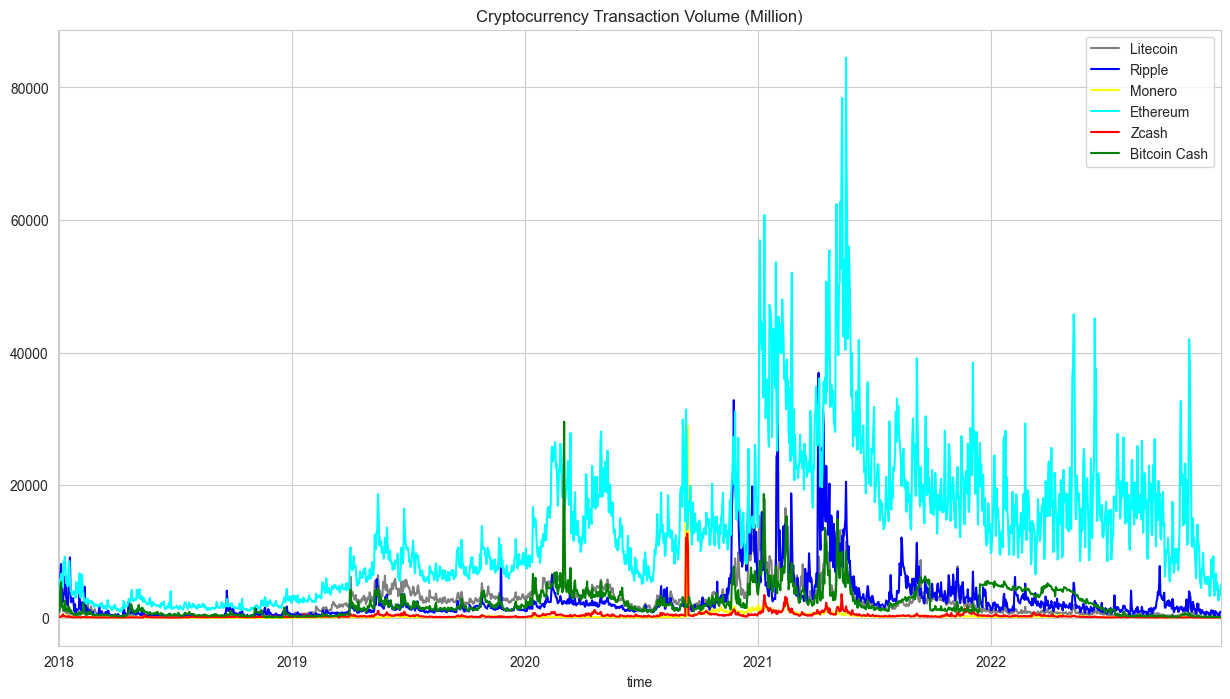

In [9]:
# plot transaction volume
#bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
monero = data[data['symbol']=='XMR']
ethereum = data[data['symbol']=='ETH']
zcash = data[data['symbol']=='ZEC']
bitcoin_cash = data[data['symbol']=='BCH']

plt.figure(figsize=(15,8))
#(bitcoin['Volume']/1000000).plot(color='darkorange', label='Bitcoin')
(litecoin['Volume']/1000000).plot(color='grey', label='Litecoin')
(ripple['Volume']/1000000).plot(color='blue', label='Ripple')
(monero['Volume']/1000000).plot(color='yellow', label='Monero')
(ethereum['Volume']/1000000).plot(color='cyan', label='Ethereum')
(zcash['Volume']/1000000).plot(color='red', label='Zcash')
(bitcoin_cash['Volume']/1000000).plot(color='green', label='Bitcoin Cash')

plt.legend()
plt.xlabel('time')
plt.title('Cryptocurrency Transaction Volume (Million)')
plt.show()

As we can see from both market capitalization and transaction volume plots, nothing really happened before 2017 (Only Bitcoin had some transactions), 2017 was seemingly a breakthrough year for the cryptocurrency ecosystem. <br>Also we find:
1. As the transaction volume of BitCoin increased, the volume of the other cryptocurrencies also increased.
2. As the price of BitCoin increased, the price of the other cryptocurrencies also increased.
3. It seems like BitCoin is leading the market changes.<br>

In [10]:
data_m = data['2017-12-01':'2017-12-31']

C:\Users\tempu\AppData\Local\Temp\ipykernel_19604\1737882125.py:1: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



As we take a closer look at one-month data for trasaction volume in December 2017 , we can clearly see that when the volume of BitCoin increased and peaked on around 12/7, other cryptocurrencies started to increase and peak a few days later.

#### In order to keep our analysis more accurate with current trend, we will be focusing on year 2017 and 2018.

In [12]:
data = data['2017-01-01':]
data.head()

C:\Users\tempu\AppData\Local\Temp\ipykernel_19604\594493758.py:1: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



,Open,High,Low,Close,Adj Close,Volume,oc_diff,symbol,Name
Date,,,,,,,,,
2017-12-31,12897.700195,14377.400391,12755.599609,14156.400391,14156.400391,12136299520,1258.700195,BTC,Bitcoin
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,-455.000000,BTC,Bitcoin
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,1357.099609,BTC,Bitcoin
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,222.799805,BTC,Bitcoin
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,328.500000,BTC,Bitcoin


### Price Fluctuation of Cryptocurrencies<a id="3-2"></a>

Check opening, closing, highest, and lowest price for each of the cryptocurrency.

In [13]:
data['oc_diff']=data['Close']-data['Open']
data.head()

,Open,High,Low,Close,Adj Close,Volume,oc_diff,symbol,Name
Date,,,,,,,,,
2017-12-31,12897.700195,14377.400391,12755.599609,14156.400391,14156.400391,12136299520,1258.700195,BTC,Bitcoin
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,-455.000000,BTC,Bitcoin
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,1357.099609,BTC,Bitcoin
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,222.799805,BTC,Bitcoin
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,328.500000,BTC,Bitcoin


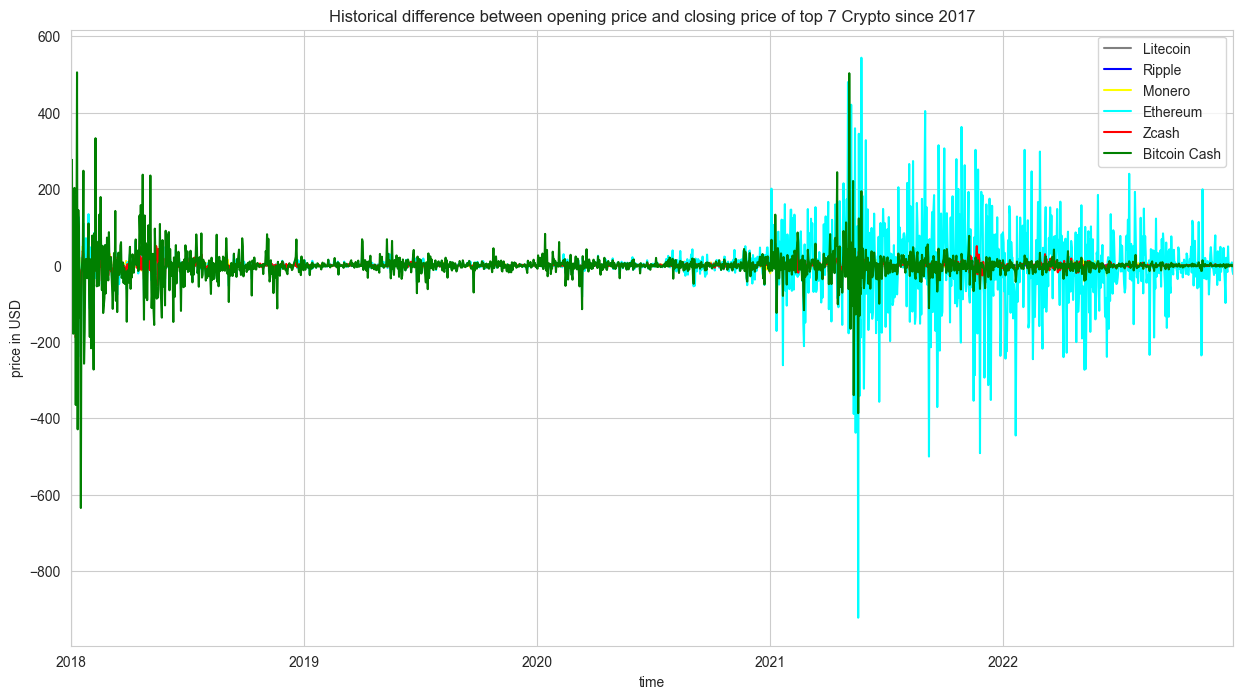

In [14]:
# Difference between opening and closing price
data['oc_diff']=data['Close']-data['Open']
#bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
monero = data[data['symbol']=='XMR']
ethereum = data[data['symbol']=='ETH']
zcash = data[data['symbol']=='ZEC']
bitcoin_cash = data[data['symbol']=='BCH']

plt.figure(figsize=(15,8))
#(bitcoin['oc_diff']).plot(color='darkorange', label='Bitcoin')
(litecoin['oc_diff']).plot(color='grey', label='Litecoin')
(ripple['oc_diff']).plot(color='blue', label='Ripple')
(monero['oc_diff']).plot(color='yellow', label='Monero')
(ethereum['oc_diff']).plot(color='cyan', label='Ethereum')
(zcash['oc_diff']).plot(color='red', label='Zcash')
(bitcoin_cash['oc_diff']).plot(color='green', label='Bitcoin Cash')

plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical difference between opening price and closing price of top 7 Crypto since 2017')
plt.legend()
plt.show()

By plotting the difference between daily opening and closing price, we found that:
1. Daily opening price and closing price of BitCoin and BitCoin Cash varies the most, the differences can range from 1000 to more than 3000 dollars.
2. The rest of the cryptocurrencies that we selected tends to be fairly stable

In [15]:
# Average difference for each cryptocurrency
ave_diff={'bitcoin':[(bitcoin['oc_diff']).mean()],
          'litecoin':[(litecoin['oc_diff']).mean()],
          'ripple':[(ripple['oc_diff']).mean()],
          'monero':[(monero['oc_diff']).mean()],
          'ethereum':[(ethereum['oc_diff']).mean()],
          'zcash':[(zcash['oc_diff']).mean()],
          'bitcoin_cash':[(bitcoin_cash['oc_diff']).mean()]}
pd.DataFrame(ave_diff, index=['avg.diff'])

,bitcoin,litecoin,ripple,monero,ethereum,zcash,bitcoin_cash
avg.diff,1258.700195,-0.105174,-0.000994,-0.123393,0.033228,-0.279772,-1.31695


### Moving Averages and Price Trend<a id="3-3"></a>

A moving average (MA) is a widely used indicator in technical analysis that helps smooth out price action by filtering out the “noise” from random price fluctuations. It is a trend-following, or lagging, indicator because it is based on past prices.

In [16]:
# calculate 5-day moving averages
btc = bitcoin[['Close']]
btc.columns = ['BTC']
btc_ma=btc.rolling(window=5).mean()

ltc = litecoin[['Close']]
ltc.columns = ['LTC']
ltc_ma=ltc.rolling(window=5).mean()

xrp = ripple[['Close']]
xrp.columns = ['XRP']
xrp_ma=xrp.rolling(window=5).mean()

xmr = monero[['Close']]
xmr.columns = ['XMR']
xmr_ma=xmr.rolling(window=5).mean()

eth = ethereum[['Close']]
eth.columns = ['ETH']
eth_ma=eth.rolling(window=5).mean()

zec = zcash[['Close']]
zec.columns = ['ZEC']
zec_ma=zec.rolling(window=5).mean()

bch = bitcoin_cash[['Close']]
bch.columns = ['BCH']
bch_ma=bch.rolling(window=5).mean()

# create matrix of close price only for later use
close = pd.concat([btc,ltc,xrp,xmr,eth,zec,bch], axis=1)
close_ma = pd.concat([btc_ma,ltc_ma,xrp_ma,xmr_ma,eth_ma,zec_ma,bch_ma], axis=1)
close_ma.tail()

,BTC,LTC,XRP,XMR,ETH,ZEC,BCH
Date,,,,,,,
2022-12-24,NaN,65.767294,0.350289,145.286542,1218.158740,40.418597,101.449594
2022-12-25,NaN,66.459271,0.349693,144.942465,1218.410425,39.961440,101.361491
2022-12-26,NaN,67.517940,0.353633,144.831934,1221.085303,39.762428,101.970282
2022-12-27,NaN,68.037187,0.357339,144.816055,1220.007202,39.631982,102.036620
2022-12-28,NaN,68.150555,0.357790,145.543210,1213.972534,39.248360,101.482133


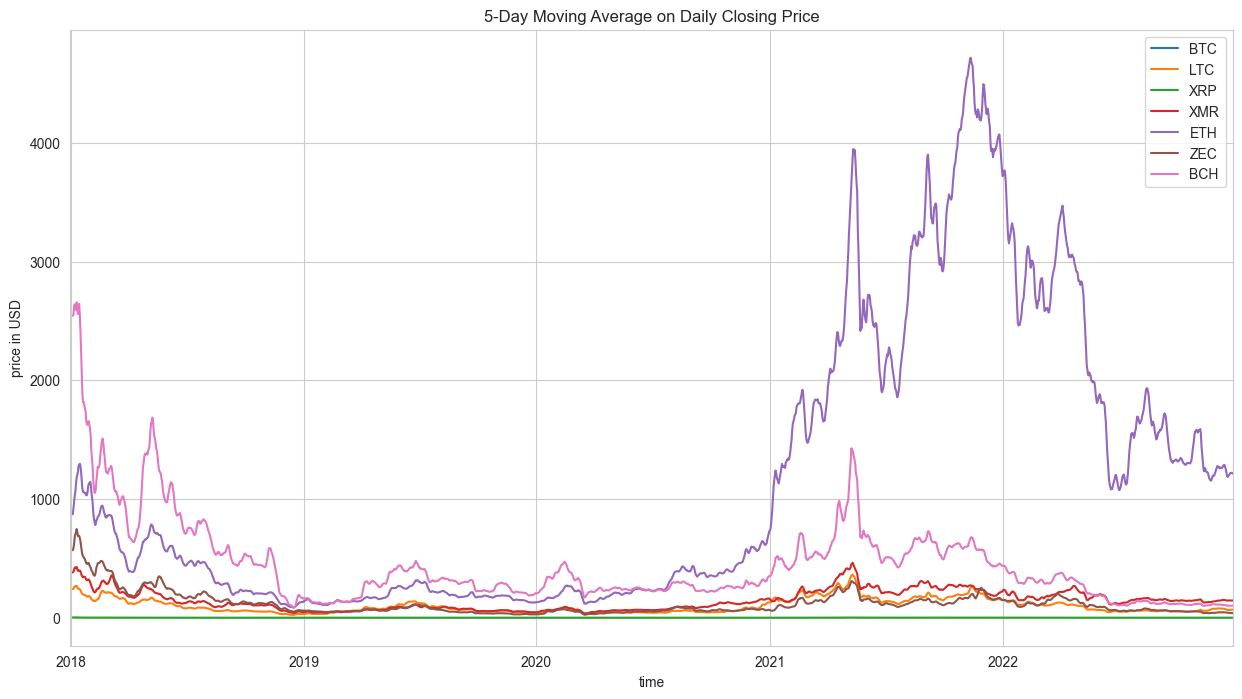

In [17]:
# plot moving average for closing price for cryptocurrencies
close_ma.plot(figsize=(15,8))
plt.title('5-Day Moving Average on Daily Closing Price')
plt.xlabel('time')
plt.ylabel('price in USD')
plt.show()

Based on the 5-day moving average plot:
1. Prices of BitCoin and BitCoin Cash fluctuate a little more than the rest of cryptocurrencies
2. Staring from January 2018, it seems like the prive of BitCoin had significantly dropped but has started to climb back around February. However, it's hard to say if BitCoin is going back to its peak in 2017.

### Market Prices of Cryptocurrencies<a id="3-4"></a>

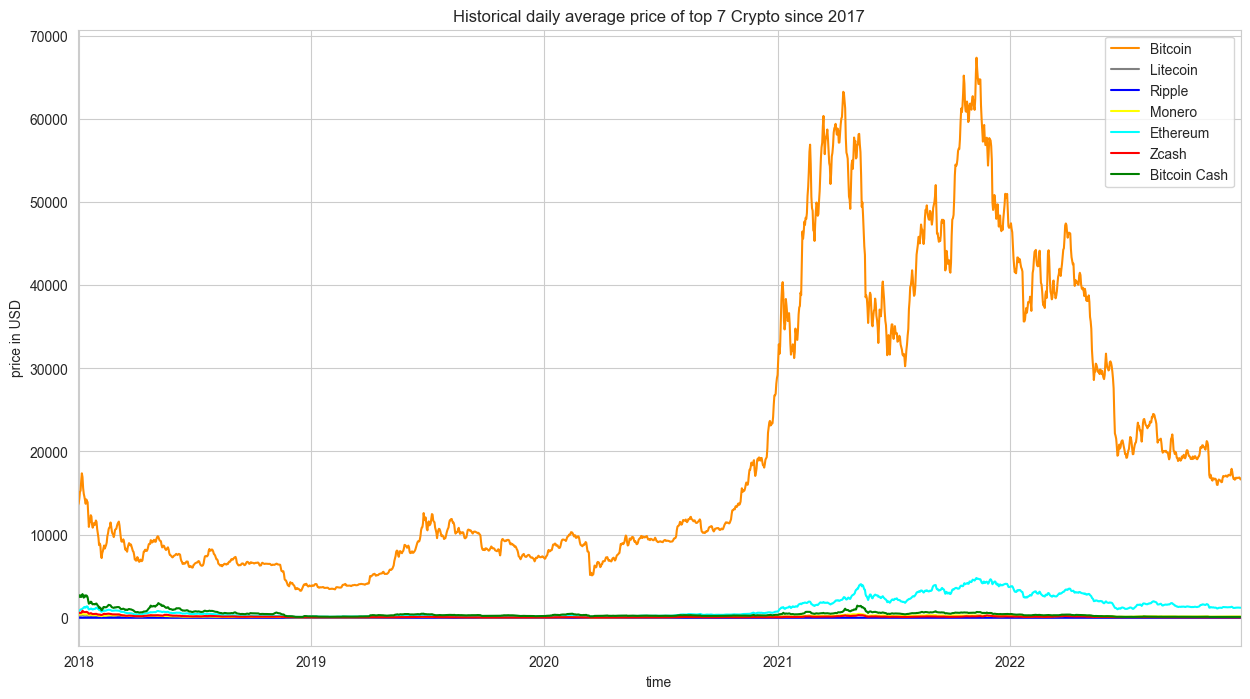

In [18]:
# calculate daily average price
data['daily_avg'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4
bitcoin = data[data['symbol']=='BTC']
litecoin = data[data['symbol']=='LTC']
ripple = data[data['symbol']=='XRP']
monero = data[data['symbol']=='XMR']
ethereum = data[data['symbol']=='ETH']
zcash = data[data['symbol']=='ZEC']
bitcoin_cash = data[data['symbol']=='BCH']

plt.figure(figsize=(15,8))
(bitcoin['daily_avg']).plot(color='darkorange', label='Bitcoin')
(litecoin['daily_avg']).plot(color='grey', label='Litecoin')
(ripple['daily_avg']).plot(color='blue', label='Ripple')
(monero['daily_avg']).plot(color='yellow', label='Monero')
(ethereum['daily_avg']).plot(color='cyan', label='Ethereum')
(zcash['daily_avg']).plot(color='red', label='Zcash')
(bitcoin_cash['daily_avg']).plot(color='green', label='Bitcoin Cash')

plt.xlabel('time')
plt.ylabel('price in USD')
plt.title('Historical daily average price of top 7 Crypto since 2017')
plt.legend()
plt.show()

#### Plot individual daily open, high, low, close prices

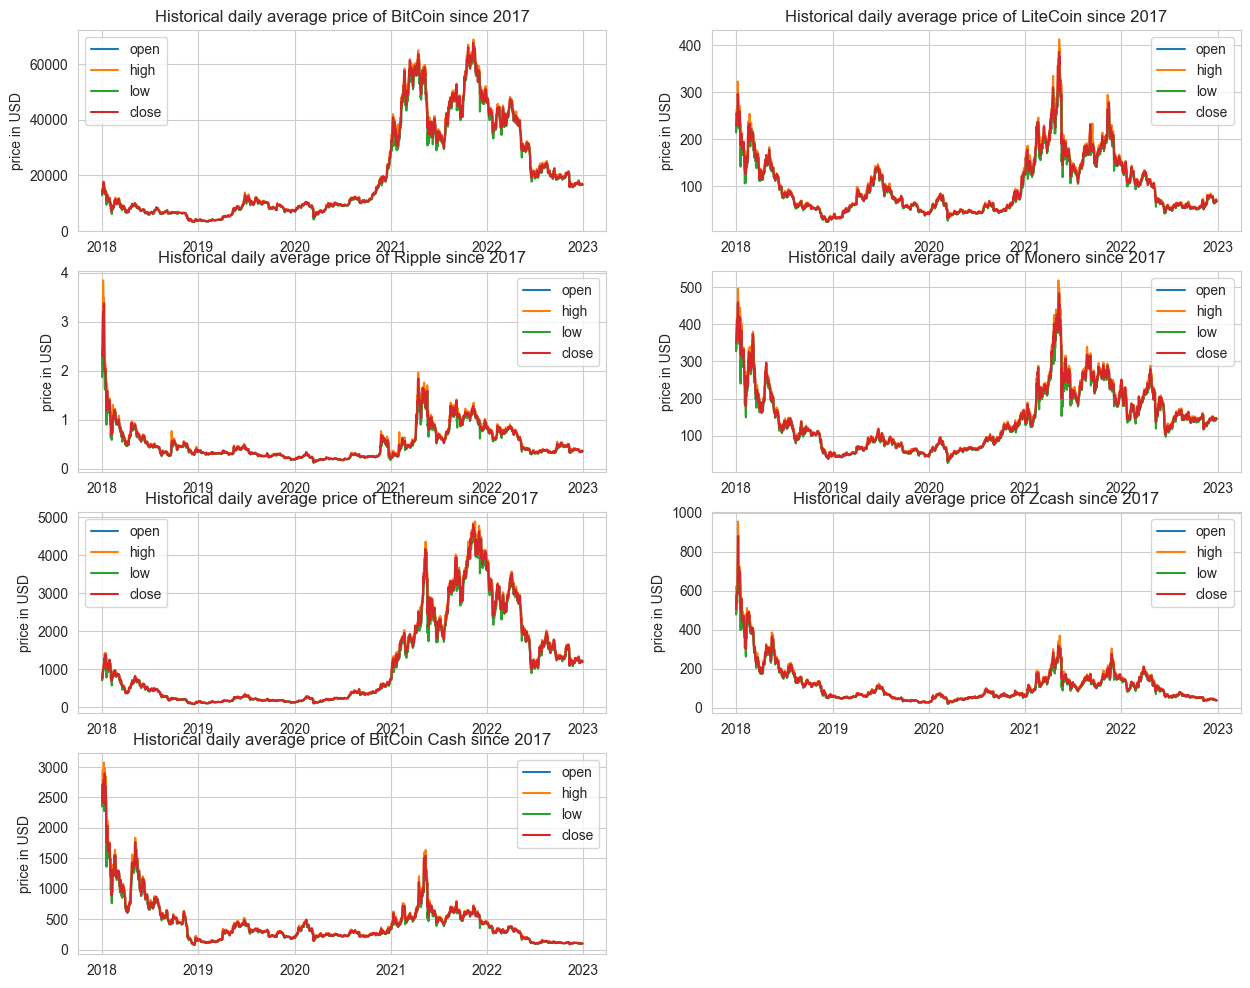

In [19]:
plt.figure(figsize=(15, 12))
plt.subplot(4,2,1)
plt.plot(bitcoin[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of BitCoin since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,2)
plt.plot(litecoin[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of LiteCoin since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,3)
plt.plot(ripple[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Ripple since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,4)
plt.plot(monero[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Monero since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,5)
plt.plot(ethereum[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Ethereum since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,6)
plt.plot(zcash[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of Zcash since 2017')
plt.legend(['open','high','low','close'])

plt.subplot(4,2,7)
plt.plot(bitcoin_cash[['Open','High','Low','Close']])
plt.ylabel('price in USD')
plt.title('Historical daily average price of BitCoin Cash since 2017')
plt.legend(['open','high','low','close'])

plt.show()

A lot of the above plots doesn't show much differences between different prices, but as we previously discovered from transaction volume and average price change, one very obvious pattern is that as the price or volume of Bitcoin increased, the price and volume of the other cryptocurrencies also increased. It's probably because the success of Bitcoin paves the way for cryptocurrency ecosystems and attracted more and more investors. Also, the high buying price of Bitcoin might triggers buys for its cheaper alternatives.

#### Check Pearson correlation coefficient to prove if BitCoin price influences price of other cryptocurrencies

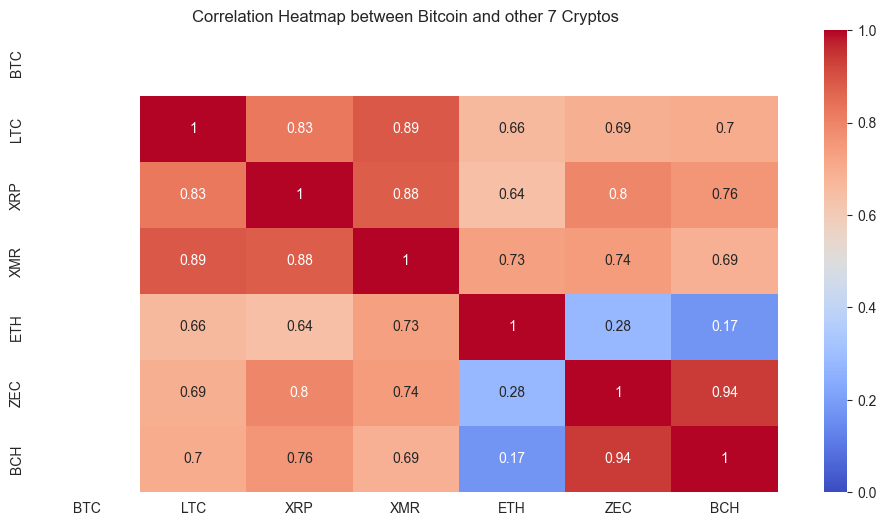

In [20]:
plt.figure(figsize=(12,6))
sns.heatmap(close.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Bitcoin and other 7 Cryptos')
plt.show()

Based on the heatmap as well as some of the previous plots, we can say that Bitcoin price does have strong impact to other cryptocurrencies. 
1. As the transaction volume of BitCoin increased, the volume of the other cryptocurrencies also increased.
2. As the price of BitCoin increased, the price of the other cryptocurrencies also increased.
3. It seems like BitCoin is leading the market changes.
4. Prices of other cryptocurrency have strong positive correaltion with price of BitCoin

### Return Ratio<a id="3-5"></a>

return ratio = current value of the cryptocurrency / initial value of the cryptocurrency

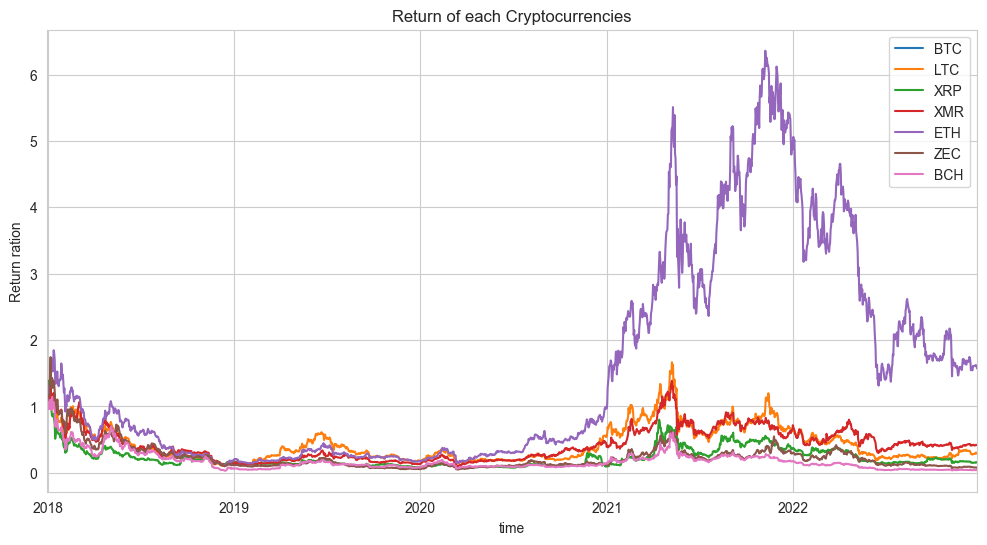

In [21]:
returns = close.apply(lambda x: x/x[0])
returns.plot(figsize=(12,6))
plt.ylabel('Return ration')
plt.xlabel('time')
plt.title('Return of each Cryptocurrencies')
plt.show()

It looks like since 2017, Ripple (XRP) and Ethereum (ETH) have the highest return ratio, while the rest of cryptocurrencies remains fairly stable. 
1. Investing in Ripple and Ethereum might get better returns but since 2018, the trend is downward.
2. Investing in popular cryptocurrencies like BitCoin and LiteCoin might still worth a try since their price is fairly stable and there seems to be an upward trend.

### Candlestick Charts Using Plotly (BitCoin)<a id="3-6"></a>

A candlestick chart (also called Japanese candlestick chart) is a style of financial chart used to describe price movements of a security, derivative, or currency. Each "candlestick" typically shows one day; so for example a one-month chart may show the 20 trading days as 20 "candlesticks".

We choose to plot a cancdlestick chart for BitCoin since everyone's super curious on whether BitCoin is going to be economic bubble or it's still something that worth to invest in.

In [22]:
increasing_color = '#17BECF'
decreasing_color = '#7F7F7F'
data_plotly = []
layout = {
    'xaxis': {
        'rangeselector': {
            'visible': True
        }
    },
    # Adding a volume bar chart for candlesticks is a good practice usually
    'yaxis': {
        'domain': [0, 0.2],
        'showticklabels': False
    },
    'yaxis2': {
        'domain': [0.2, 0.8]
    },
    'legend': {
        'orientation': 'h',
        'y': 0.9,
        'yanchor': 'bottom'
    },
    'margin': {
        't': 40,
        'b': 40,
        'r': 40,
        'l': 40
    }
}

# Defining main chart
trace0 = go.Candlestick(
    x=bitcoin.index, open=bitcoin['Open'], high=bitcoin['High'],
    low=bitcoin['Low'], close=bitcoin['Close'],
    yaxis='y2', name='bitcoin',
    increasing=dict(line=dict(color=increasing_color)),
    decreasing=dict(line=dict(color=decreasing_color)),
)

data_plotly.append(trace0)

# Adding some range buttons to interact
rangeselector = {
    'visible': True,
    'x': 0,
    'y': 0.8,
    'buttons': [
        {'count': 1, 'label': 'reset', 'step': 'all'},
        {'count': 6, 'label': '6 mo', 'step': 'month', 'stepmode': 'backward'},
        {'count': 3, 'label': '3 mo', 'step': 'month', 'stepmode': 'backward'},
        {'count': 1, 'label': '1 mo', 'step': 'month', 'stepmode': 'backward'},
    ]
}

layout['xaxis'].update(rangeselector=rangeselector)

# Setting volume bar chart colors
colors = []
for i, _ in enumerate(bitcoin.index):
    if i != 0:
        if bitcoin['Close'].iloc[i] > bitcoin['Close'].iloc[i-1]:
            colors.append(increasing_color)
        else:
            colors.append(decreasing_color)
    else:
        colors.append(decreasing_color)

trace1 = go.Bar(
    x=bitcoin.index, y=bitcoin['Volume'],
    marker=dict(color=colors),
    yaxis='y', name='Volume'
)

data_plotly.append(trace1)

# Adding Moving Average
def moving_average(interval, window_size=10):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'same')

trace2 = go.Scatter(
    x=bitcoin.index[5:-5], y=moving_average(bitcoin['Close'])[5:-5],
    yaxis='y2', name='Moving Average',
    line=dict(width=1)
)

data_plotly.append(trace2)

# Adding boilinger bands
def bollinger_bands(price, window_size=10, num_of_std=5):
    rolling_mean = price.rolling(10).mean()
    rolling_std = price.rolling(10).std()
    upper_band = rolling_mean + (rolling_std * 5)
    lower_band = rolling_mean - (rolling_std * 5)
    return upper_band, lower_band

bb_upper, bb_lower = bollinger_bands(bitcoin['Close'])

trace3 = go.Scatter(
    x=bitcoin.index, y=bb_upper,
    yaxis='y2', line=dict(width=1),
    marker=dict(color='#ccc'), hoverinfo='none',
    name='Bollinger Bands',
    legendgroup='Bollinger Bands'
)
data_plotly.append(trace3)

trace4 = go.Scatter(
    x=bitcoin.index, y=bb_lower,
    yaxis='y2', line=dict(width=1),
    marker=dict(color='#ccc'), hoverinfo='none',
    name='Bollinger Bands', showlegend=False,
    legendgroup='Bollinger Bands'
)
data_plotly.append(trace4)
fig = go.Figure(data=data_plotly, layout=layout)
py.iplot(fig, filename='bitcoin-candlestick')

How to read the candlestick chart:
<img src='http://www.greenboxmarkets.com/wp-content/uploads/2016/08/japanese-candlesticks-chart-introduction-1.jpg'>
1. Blue colored candlestick means if the price of bitcoin is increasing for that day compares to previous day, while the grey candlestick means the price is decreasing.
2. The red trend line is indicating the moving average of 10 days.
3. Bollinger Bands consist of: an N-period moving average (MA) an upper band at K times an N-period standard deviation above the moving average (MA + Kσ) a lower band at K times an N-period standard deviation below the moving average (MA − Kσ). 
4. The bottom chart is the time range.
5. Each candlestick gives 4 daily values: open, high, low, and close. (If there's less value, that means two or more of the value is the same)
6. Based on the chart, and based onthe last candlestick, we can infer from its large body but short wick that the price might keep dropping after February 22nd.

#### [Back to Top](#0)

## 4. Building Models - Predicting Price for Cryptocurrencies<a id="4"></a>

### Prepare Data for Models<a id="4-1"></a>

I will separate the data set and build model on each cryptocurrencie type.

For data preparation, I will follow below steps:
1. remove 'slug', 'name', 'symbol' and ''ranknow' from data set
2. move all 'daily_avg' values 30 lines up in our last cell(one month lag) and define a new column, 'daily_avg_After_Month'
3. choose 'daily_avg_After_Month' as target and all other variables as predictors
4. create train and test data by splitting the data set to 80-20
5. create 'X_forecast' using all predictors with NA 'daily_avg_After_Month' (to predict price in next 30 days)

In [23]:
# droping 'slug' and 'name' as we can just use 'symbol', and droping 'ranknow'.
data=data.drop(['Name'], axis=1)

# Bitcoin (BTC)
BTC = data[data.symbol == 'BTC'].copy()
BTC['daily_avg_After_Month']=BTC['daily_avg'].shift(-30)
X_BTC = BTC.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_BTC = BTC.dropna()['daily_avg_After_Month']
X_train_BTC, X_test_BTC, y_train_BTC, y_test_BTC = train_test_split(X_BTC, y_BTC, test_size=0.2, random_state=43)
X_forecast_BTC =  BTC.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Ethereum (ETH)
ETH = data[data.symbol == 'ETH'].copy()
ETH['daily_avg_After_Month']=ETH['daily_avg'].shift(-30)
X_ETH = ETH.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_ETH = ETH.dropna()['daily_avg_After_Month']
X_train_ETH, X_test_ETH, y_train_ETH, y_test_ETH = train_test_split(X_ETH, y_ETH, test_size=0.2, random_state=43)
X_forecast_ETH =  ETH.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Litecoin (LTC)
LTC = data[data.symbol == 'LTC'].copy()
LTC['daily_avg_After_Month']=LTC['daily_avg'].shift(-30)
X_LTC = LTC.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_LTC = LTC.dropna()['daily_avg_After_Month']
X_train_LTC, X_test_LTC, y_train_LTC, y_test_LTC = train_test_split(X_LTC, y_LTC, test_size=0.2, random_state=43)
X_forecast_LTC =  LTC.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Bitcoin Cash (BCH)
BCH = data[data.symbol == 'BCH'].copy()
BCH['daily_avg_After_Month']=BCH['daily_avg'].shift(-30)
X_BCH = BCH.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_BCH = BCH.dropna()['daily_avg_After_Month']
X_train_BCH, X_test_BCH, y_train_BCH, y_test_BCH = train_test_split(X_BCH, y_BCH, test_size=0.2, random_state=43)
X_forecast_BCH =  BCH.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Ripple (XRP)
XRP = data[data.symbol == 'XRP'].copy()
XRP['daily_avg_After_Month']=XRP['daily_avg'].shift(-30)
X_XRP = XRP.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_XRP = XRP.dropna()['daily_avg_After_Month']
X_train_XRP, X_test_XRP, y_train_XRP, y_test_XRP = train_test_split(X_XRP, y_XRP, test_size=0.2, random_state=43)
X_forecast_XRP =  XRP.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Monero (XMR)
XMR = data[data.symbol == 'XMR'].copy()
XMR['daily_avg_After_Month']=XMR['daily_avg'].shift(-30)
X_XMR = XMR.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_XMR = XMR.dropna()['daily_avg_After_Month']
X_train_XMR, X_test_XMR, y_train_XMR, y_test_XMR = train_test_split(X_XMR, y_XMR, test_size=0.2, random_state=43)
X_forecast_XMR =  XMR.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

# Zcash (ZEC)
ZEC = data[data.symbol == 'ZEC'].copy()
ZEC['daily_avg_After_Month']=ZEC['daily_avg'].shift(-30)
X_ZEC = ZEC.dropna().drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)
y_ZEC = ZEC.dropna()['daily_avg_After_Month']
X_train_ZEC, X_test_ZEC, y_train_ZEC, y_test_ZEC = train_test_split(X_ZEC, y_ZEC, test_size=0.2, random_state=43)
X_forecast_ZEC =  ZEC.tail(30).drop(['daily_avg_After_Month','symbol','daily_avg'], axis=1)

### Applying Machine Learning Models<a id="4-2"></a>

In [24]:
# define regression function
def regression(X_train, X_test, y_train, y_test):
    Regressor = {
        'Random Forest Regressor': RandomForestRegressor(n_estimators=200),
        'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=500),
        'ExtraTrees Regressor': ExtraTreesRegressor(n_estimators=500, min_samples_split=5),
        'Bayesian Ridge': BayesianRidge(),
        'Elastic Net CV': ElasticNetCV()
    }

    for name, clf in Regressor.items():
        print(name)
        clf.fit(X_train, y_train)
    
        print(f'R2: {r2_score(y_test, clf.predict(X_test)):.2f}')
        print(f'MAE: {mean_absolute_error(y_test, clf.predict(X_test)):.2f}')
        print(f'MSE: {mean_squared_error(y_test, clf.predict(X_test)):.2f}')
        print()

In [25]:
# Bitcoin (BTC)
print('Bitcoin (BTC):')
regression(X_train_BTC, X_test_BTC, y_train_BTC, y_test_BTC)

Bitcoin (BTC):
Random Forest Regressor
R2: 0.93
MAE: 2521.64
MSE: 20061365.28

Gradient Boosting Regressor
R2: 0.91
MAE: 2913.42
MSE: 23826896.56

ExtraTrees Regressor
R2: 0.93
MAE: 2503.12
MSE: 18513987.18

Bayesian Ridge
R2: 0.89
MAE: 3412.29
MSE: 30622926.24

Elastic Net CV
R2: 0.33
MAE: 10660.11
MSE: 180258681.53



In [26]:
# Ethereum (ETH)
print('Ethereum (ETH):')
regression(X_train_ETH, X_test_ETH, y_train_ETH, y_test_ETH)

Ethereum (ETH):
Random Forest Regressor
R2: 0.90
MAE: 189.57
MSE: 133336.86

Gradient Boosting Regressor
R2: 0.89
MAE: 203.43
MSE: 149242.75

ExtraTrees Regressor
R2: 0.90
MAE: 188.61
MSE: 132440.02

Bayesian Ridge
R2: 0.88
MAE: 238.11
MSE: 157921.48

Elastic Net CV
R2: 0.30
MAE: 753.70
MSE: 954420.51



In [27]:
# Litecoin (LTC)
print('Litecoin (LTC):')
regression(X_train_LTC, X_test_LTC, y_train_LTC, y_test_LTC)

Litecoin (LTC):
Random Forest Regressor
R2: 0.80
MAE: 16.82
MSE: 670.35

Gradient Boosting Regressor
R2: 0.75
MAE: 18.32
MSE: 843.42

ExtraTrees Regressor
R2: 0.79
MAE: 17.14
MSE: 707.98

Bayesian Ridge
R2: 0.75
MAE: 20.72
MSE: 855.70

Elastic Net CV
R2: 0.16
MAE: 43.40
MSE: 2857.18



In [28]:
# Bitcoin Cash (BCH)
print('Bitcoin Cash (BCH):')
regression(X_train_BCH, X_test_BCH, y_train_BCH, y_test_BCH)

Bitcoin Cash (BCH):
Random Forest Regressor
R2: 0.81
MAE: 73.76
MSE: 14894.31

Gradient Boosting Regressor
R2: 0.76
MAE: 84.25
MSE: 18348.26

ExtraTrees Regressor
R2: 0.78
MAE: 79.58
MSE: 16861.59

Bayesian Ridge
R2: 0.64
MAE: 102.77
MSE: 27769.93

Elastic Net CV
R2: -0.01
MAE: 215.39
MSE: 78273.85



In [29]:
# Ripple (XRP)
print('Ripple (XRP):')
regression(X_train_XRP, X_test_XRP, y_train_XRP, y_test_XRP)

Ripple (XRP):
Random Forest Regressor
R2: 0.76
MAE: 0.10
MSE: 0.02

Gradient Boosting Regressor
R2: 0.68
MAE: 0.11
MSE: 0.03

ExtraTrees Regressor
R2: 0.75
MAE: 0.10
MSE: 0.02

Bayesian Ridge
R2: 0.56
MAE: 0.13
MSE: 0.04

Elastic Net CV
R2: 0.10
MAE: 0.23
MSE: 0.08



In [30]:
# Monero (XMR)
print('Monero (XMR):')
regression(X_train_XMR, X_test_XMR, y_train_XMR, y_test_XMR)

Monero (XMR):
Random Forest Regressor
R2: 0.78
MAE: 22.74
MSE: 1371.42

Gradient Boosting Regressor
R2: 0.77
MAE: 24.19
MSE: 1454.48

ExtraTrees Regressor
R2: 0.80
MAE: 22.71
MSE: 1254.09

Bayesian Ridge
R2: 0.69
MAE: 29.30
MSE: 1947.87

Elastic Net CV
R2: 0.00
MAE: 64.20
MSE: 6339.16



In [31]:
# Zcash (ZEC)
print('Zcash (ZEC):')
regression(X_train_ZEC, X_test_ZEC, y_train_ZEC, y_test_ZEC)

Zcash (ZEC):
Random Forest Regressor
R2: 0.81
MAE: 20.41
MSE: 1042.69

Gradient Boosting Regressor
R2: 0.79
MAE: 22.66
MSE: 1172.24

ExtraTrees Regressor
R2: 0.80
MAE: 21.98
MSE: 1110.16

Bayesian Ridge
R2: 0.72
MAE: 26.61
MSE: 1545.87

Elastic Net CV
R2: -0.01
MAE: 57.85
MSE: 5667.95



As for all the five algorithms, I will end up taking Extra Trees Regressor for all cryptos but XRP and LTC, since this algorithm perform better than all other algorithms in all indicators(R2, MAE and MSE).

For XRP and LTC, the Random Forest Regressor perform distinctly better than all other algorithms. 

### Prices Prediction<a id="4-3"></a>

In [32]:
# define prediction function
def prediction(name, X, y, X_forecast):
    if name in ['XRP', 'LTC']:
        model = RandomForestRegressor(n_estimators=200)
    else:
        model = ExtraTreesRegressor(n_estimators=500, min_samples_split=5)
    model.fit(X, y)
    target = model.predict(X_forecast)
    return target

In [33]:
# calculate forecasted prices for next 30 days
forecasted_BTC = prediction('BTC', X_BTC, y_BTC, X_forecast_BTC)
forecasted_ETH = prediction('ETH', X_ETH, y_ETH, X_forecast_ETH)
forecasted_LTC = prediction('LTC', X_LTC, y_LTC, X_forecast_LTC)
forecasted_BCH = prediction('BCH', X_BCH, y_BCH, X_forecast_BCH)
forecasted_XRP = prediction('XRP', X_XRP, y_XRP, X_forecast_XRP)
forecasted_XMR = prediction('XMR', X_XMR, y_XMR, X_forecast_XMR)
forecasted_ZEC = prediction('ZEC', X_ZEC, y_ZEC, X_forecast_ZEC)

In [34]:
# define index for next 30 days
last_date=data.iloc[-1].name
modified_date = last_date + dt.timedelta(days=1)
new_date = pd.date_range(modified_date,periods=30,freq='D')

# assign prediction to newly defined index
forecasted_BTC = pd.DataFrame(forecasted_BTC, columns=['daily_avg'], index=new_date)
forecasted_ETH = pd.DataFrame(forecasted_ETH, columns=['daily_avg'], index=new_date)
forecasted_LTC = pd.DataFrame(forecasted_LTC, columns=['daily_avg'], index=new_date)
forecasted_BCH = pd.DataFrame(forecasted_BCH, columns=['daily_avg'], index=new_date)
forecasted_XRP = pd.DataFrame(forecasted_XRP, columns=['daily_avg'], index=new_date)
forecasted_XMR = pd.DataFrame(forecasted_XMR, columns=['daily_avg'], index=new_date)
forecasted_ZEC = pd.DataFrame(forecasted_ZEC, columns=['daily_avg'], index=new_date)

# combine historical price and predicted price
bitcoin = pd.concat([data[data['symbol']=='BTC'][['daily_avg']], forecasted_BTC])
litecoin = pd.concat([data[data['symbol']=='LTC'][['daily_avg']], forecasted_LTC])
ripple = pd.concat([data[data['symbol']=='XRP'][['daily_avg']], forecasted_XRP])
monero = pd.concat([data[data['symbol']=='XMR'][['daily_avg']], forecasted_XMR])
ethereum = pd.concat([data[data['symbol']=='ETH'][['daily_avg']], forecasted_ETH])
zcash = pd.concat([data[data['symbol']=='ZEC'][['daily_avg']], forecasted_ZEC])
bitcoin_cash = pd.concat([data[data['symbol']=='BCH'][['daily_avg']], forecasted_BCH])

#### Bitcoin
Looking at the short-term forcasted trend in next month, the predicted price of Bitcoin is still volatile. Downward trending follows right after an increasing price trend, mainly because of the lacking of momentum. Investors need to be cautious with the drastic price flunctuation. Traders are advised to buy a **short-term put option** and **long-term call option**.

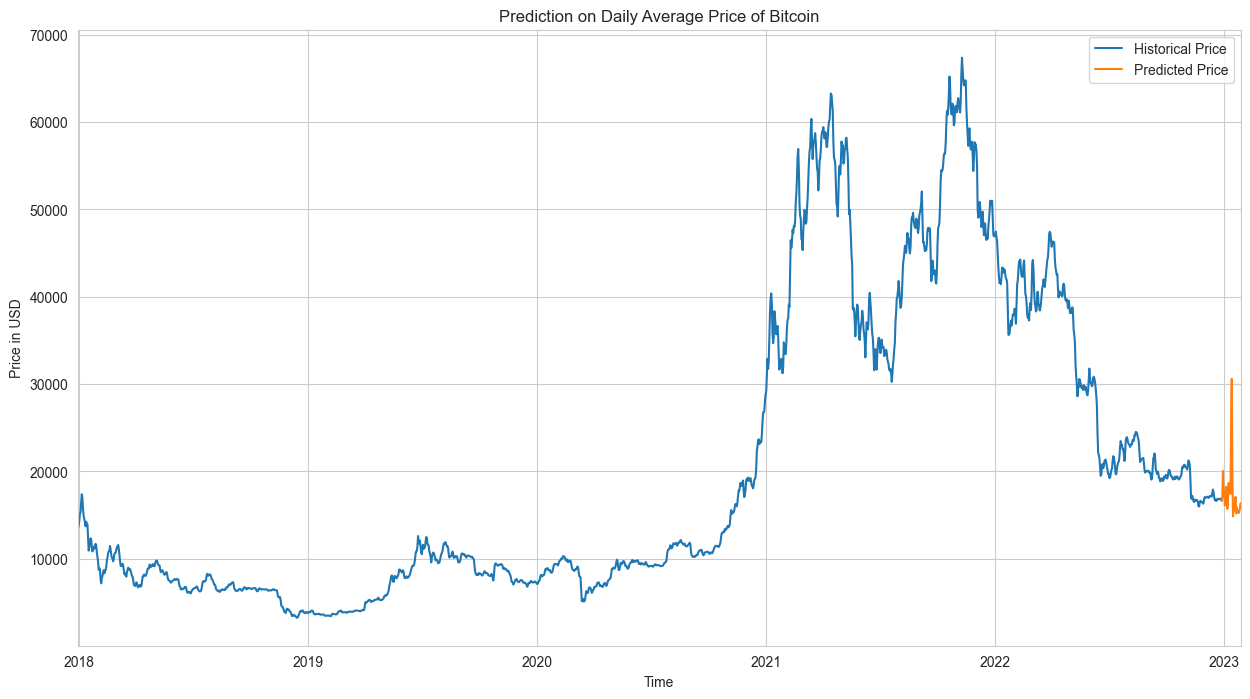

In [35]:
plt.figure(figsize=(15,8))
(bitcoin[:-30]['daily_avg']).plot(label='Historical Price')
(bitcoin[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Bitcoin')
plt.legend()
plt.show()

#### Litcoin
The predicted price of Litcoin is still volatile. The lack in momentum is obvious in Litcoin's price. In the short term, Litcion holder is advertise to sell the coin in the near future, and traders are advised to buy a **short-term put option** and **long-term call option**.

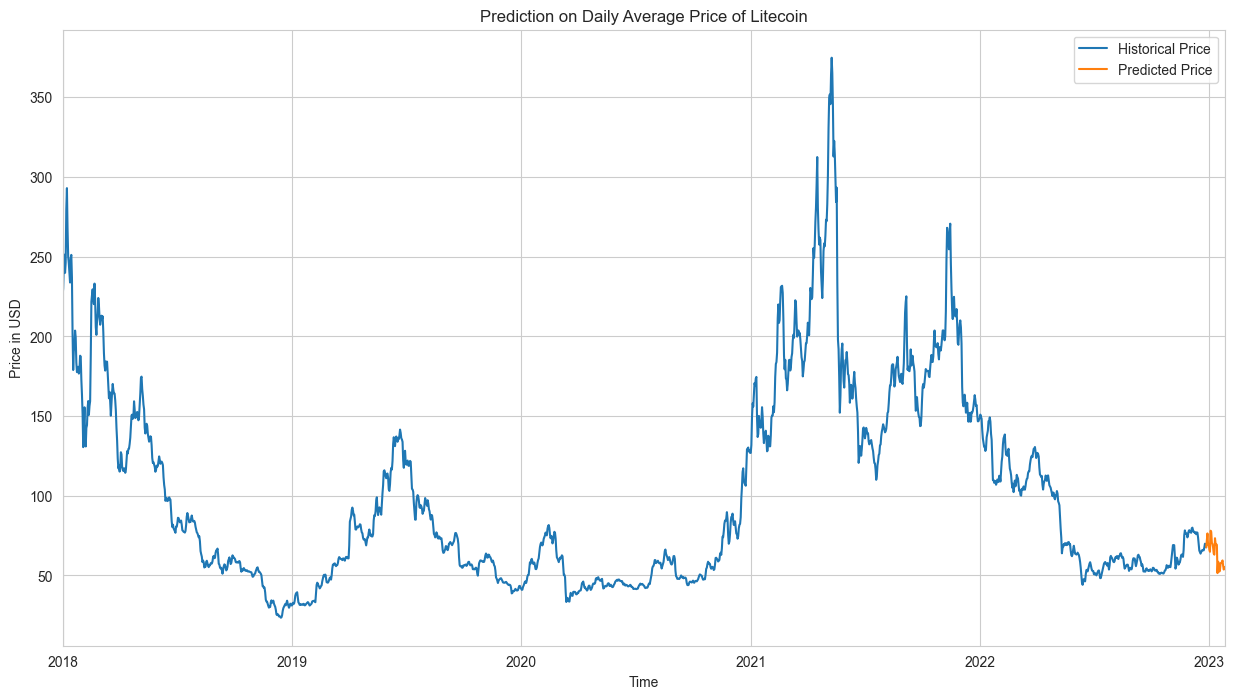

In [36]:
plt.figure(figsize=(15,8))
(litecoin[:-30]['daily_avg']).plot(label='Historical Price')
(litecoin[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Litecoin')
plt.legend()
plt.show()

#### Ripple
The predicted price of Ripple is volitle. Ripple's price is extremely dependent on the market perfotmance, investors are advised to stand on **a short position**.  

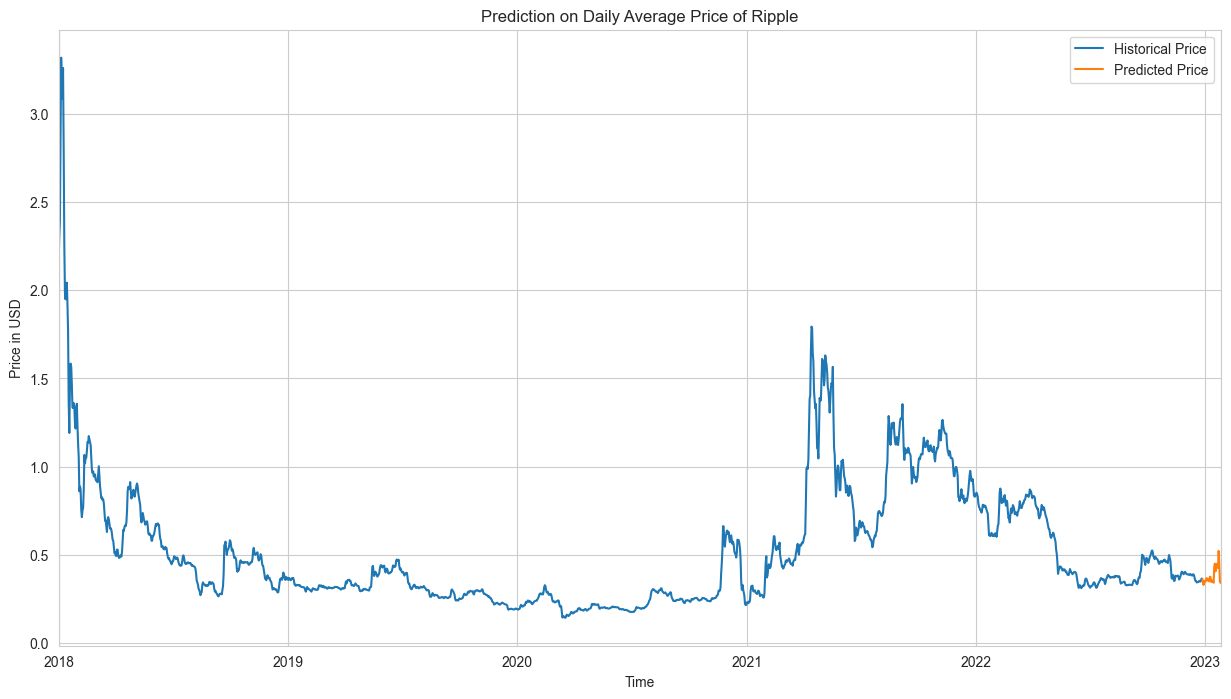

In [37]:
plt.figure(figsize=(15,8))
(ripple[:-30]['daily_avg']).plot(label='Historical Price')
(ripple[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Ripple')
plt.legend()
plt.show()

#### Ehereum
Similar to Bitcoin, the predicted price of Ehereum is volitle. Downward trending follows right after an increasing price trend, mainly because of the lacking of momentum. 

Investors need to be cautious with the drastic price flunctuation as the price has been gone very high. Traders are advised to buy a **short-term put option** and **long-term call option**.

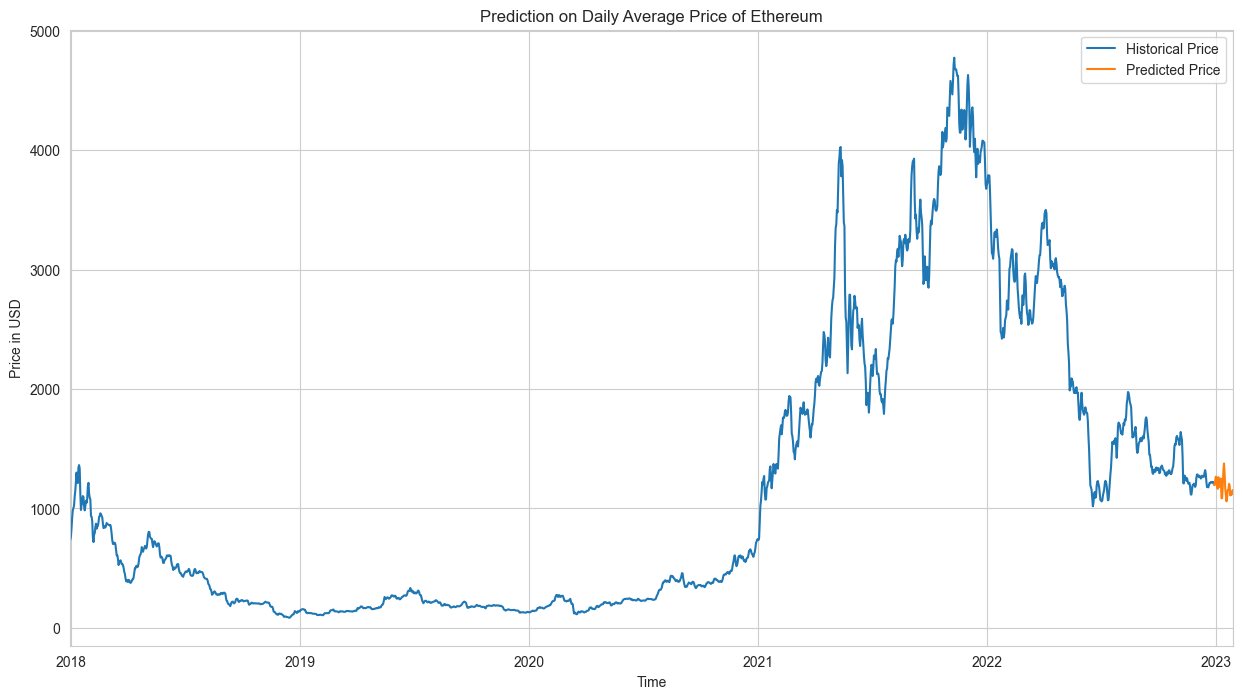

In [38]:
plt.figure(figsize=(15,8))
(ethereum[:-30]['daily_avg']).plot(label='Historical Price')
(ethereum[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Ethereum')
plt.legend()
plt.show()

#### Monero
After a short increase, Monero's price will go into a box area. Monero's good for short-term investment where investors can sell high and buy low. To see future trend of the price, investors need to observe sharply whether the price hit the top or botton of the box area, and determine whether the box goes down or high.

source: [Darvas Box Theory](https://www.investopedia.com/terms/d/darvasboxtheory.asp)

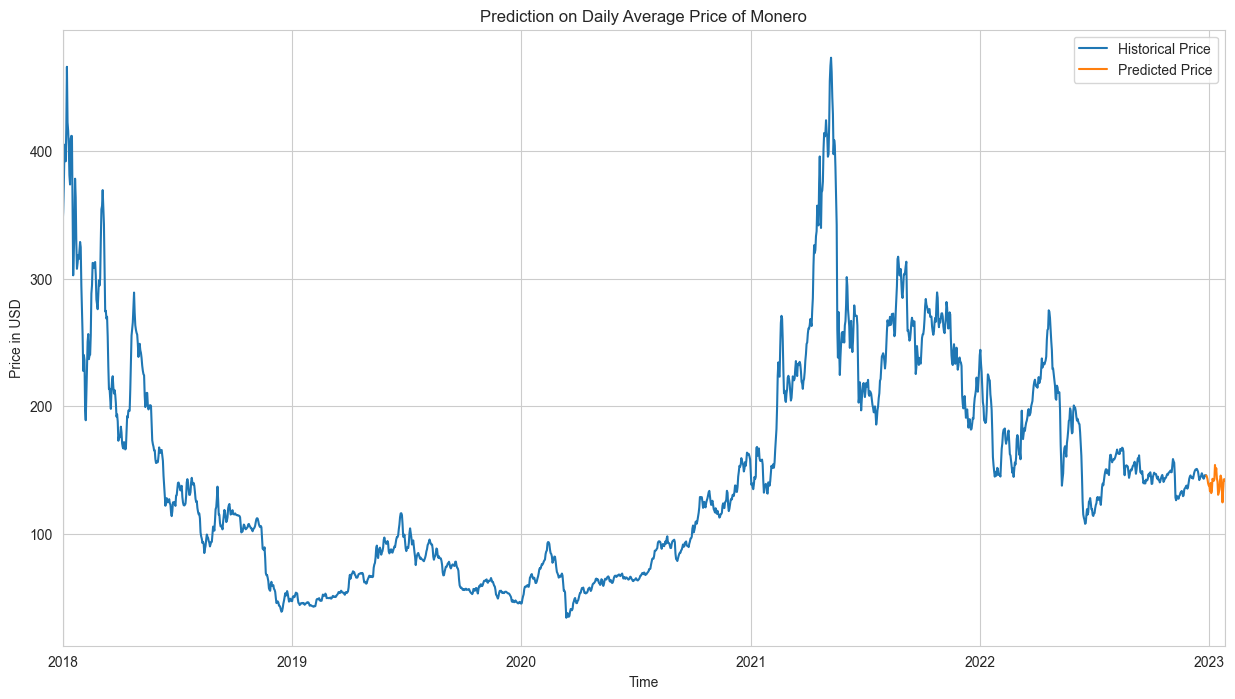

In [39]:
plt.figure(figsize=(15,8))
(monero[:-30]['daily_avg']).plot(label='Historical Price')
(monero[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Monero')
plt.legend()
plt.show()

#### Zcash
Zcash started as an alternative to Bitcoin. However, unlike Bitcoin which utilizes only blockchain technology for transaction, Zcash uses zk-snarks an extra optional encrypted and more secure system to ensure that all the information regarding user transactions is safely encrypted. Zcash boasts of a solid technology and strong privacy features which sets it apart from other cryptocurrencies.

The price for now is relatively low, we advice investors not to take a short - term operation, rather **take a long position**, as shown on the prediction that it will enter into a box area at its high price. 

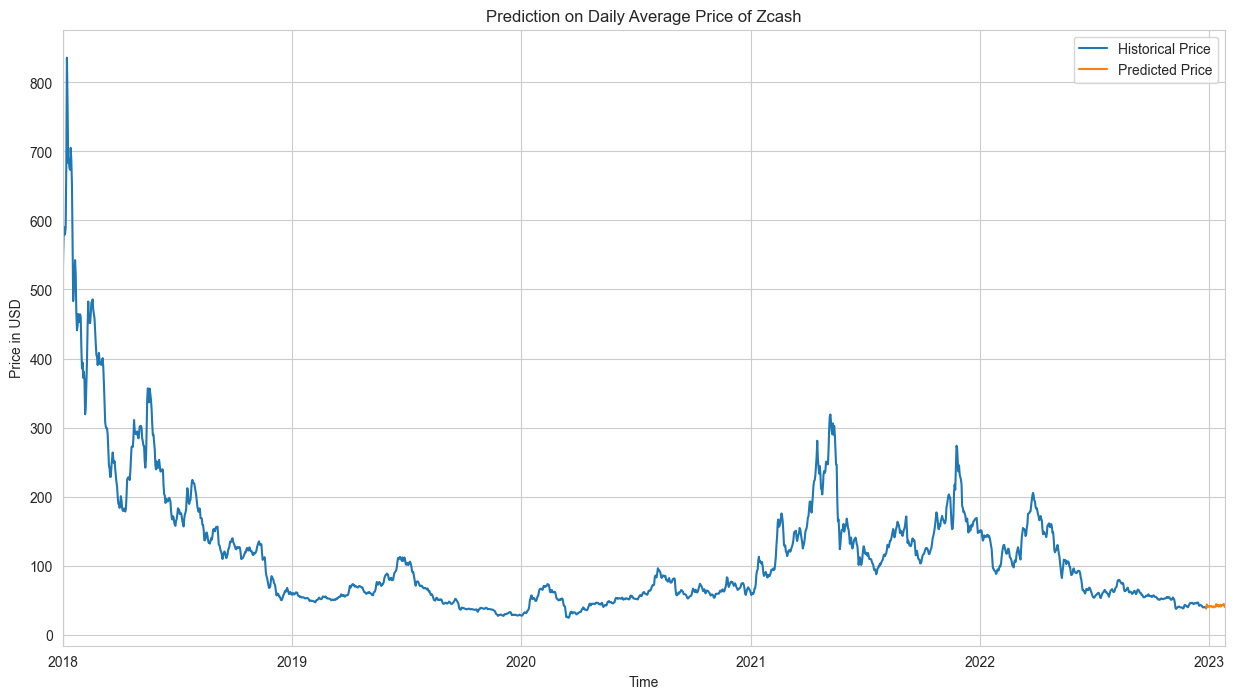

In [40]:
plt.figure(figsize=(15,8))
(zcash[:-30]['daily_avg']).plot(label='Historical Price')
(zcash[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Zcash')
plt.legend()
plt.show()

#### Bitcoin Cash:
Bitcoin Cash was started by Bitcoin miners and developers equally concerned with the future of the cryptocurrency, and its ability to scale effectively. The jump in December is due to Coinbase announced they will be adding BCH as the forth coin they will supporting on the platform. In this sense, Bitcoin Cash is very likely a great “investment” **now**.

The future trend is shown as highly volatile. Investors might want to **take a long position** on BCH and don't trade BCH easily to earn short term wins.


Source: [Bitcoin vs. Bitcoin Cash: What's the Difference?](https://www.investopedia.com/tech/bitcoin-vs-bitcoin-cash-whats-difference/)

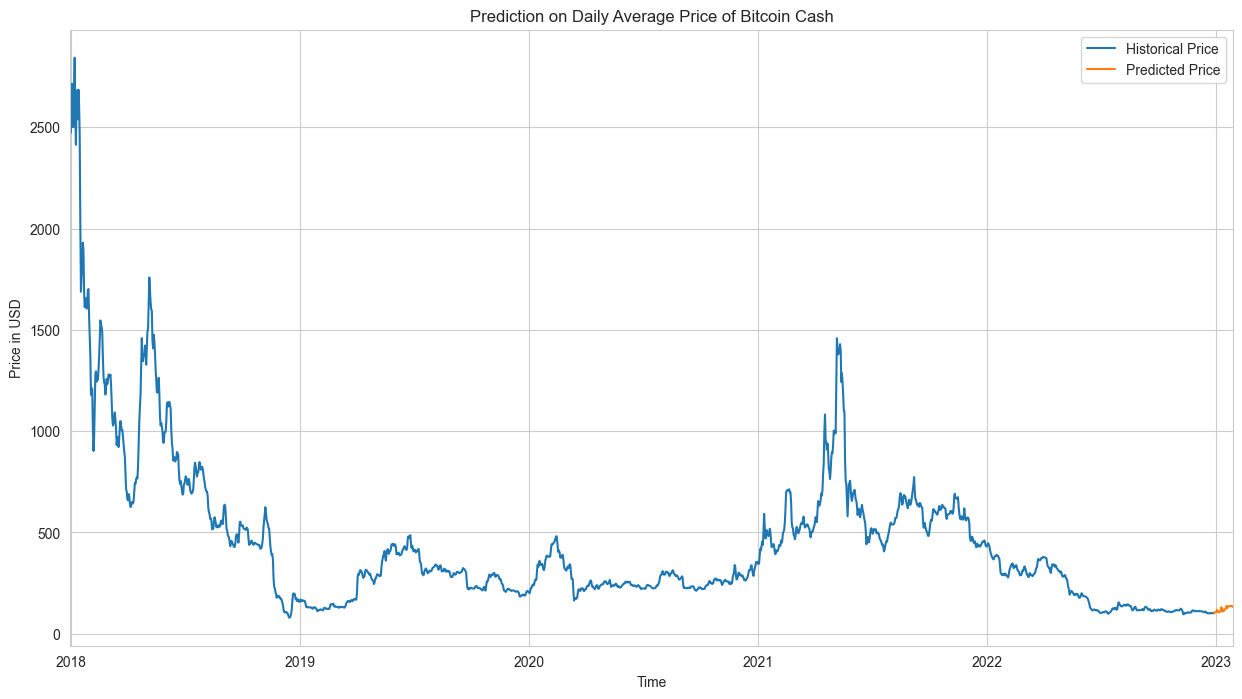

In [41]:
plt.figure(figsize=(15,8))
(bitcoin_cash[:-30]['daily_avg']).plot(label='Historical Price')
(bitcoin_cash[-31:]['daily_avg']).plot(label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.title('Prediction on Daily Average Price of Bitcoin Cash')
plt.legend()
plt.show()

### How to maximize your short term investment gains?<a id="5-1"></a>


**10% to 25% in Bitcoin (BTC) and Ethereum (ETH).** Bitcoin and Ethereum are the main drivers of the cryptocurrency markets and the markets often mirror their performance. These coins represent a solid foundation to any portfolio but will be outperformed in the short to medium term by altcoins and ICOs. As a result, limit your investments in these coins.

**25% to 55% in stock market**, in contrast to cryptocurrency which A 10% drop in prices over the course of 24 hours is no longer as alarming as it used to be, stock market is as a safer place comparably where drastic fall in price is less likely to happen.

**25% to 55% in savings and Funds**, the safest place to put money is still in the bank. Depending on the risk averseness of an investor, it's advised to put 25% to 55% of their investment to bank or investment funds.

**10% to 15% in swing trading and/or day trading**, the more volatile cryptocurrencies such as Lisk (LSK) and OmiseGO (OMG) which record high daily trade volumes are good options for both swing and day trading. Traders should seek to benefit from price fluctuations and should utilize the leverage trading options provided by some of the top exchanges. More experienced traders should make use of shorting orders to also benefit from drops in price.


***